<a href="https://colab.research.google.com/github/seongilp/CIFAR10/blob/main/cifar10_dfe4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Config():
    def __init__(self):
        self.modelname = "ResNet32"  # MLP / LeNet5 / ResNet32
        self.batch_size = 128
        self.lr = 0.1
        self.momentum = 0.9
        self.weight_decay = 1e-04
        self.finish_step = 15000

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LeNet5_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # kernel size, stride, padding = 0 (default)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # input features, output features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class IdentityPadding(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.pooling = nn.MaxPool2d(kernel_size=1, stride=stride)
        self.add_channels = out_channels - in_channels

    def forward(self, x):
        # 패딩전 x: torch.Size([200, 32, 16, 16])
        x = F.pad(x, [0, 0, 0, 0, 0, self.add_channels])
        # 패딩후 x: torch.Size([200, 64, 16, 16])
        x = self.pooling(x)
        # 풀링후 x: torch.Size([200, 64, 8, 8])
        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        if down_sample:
            self.down_sample = IdentityPadding(in_channels, out_channels, stride)
        else:
            self.down_sample = None

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.down_sample is not None:
            shortcut = self.down_sample(shortcut)

        x += shortcut
        x = self.relu(x)
        return x


class ResNet(nn.Module):

    def __init__(self, num_layers, num_classes=10):
        super().__init__()
        # input img : [3, 32, 32]
        self.num_layers = num_layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,
                               kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        block = ResidualBlock

        # feature map size = [16,32,32]
        self.layers_2n = self.get_layers(block, 16, 16, stride=1)
        # feature map size = [32,16,16]
        self.layers_4n = self.get_layers(block, 16, 32, stride=2)
        # feature map size = [64,8,8]
        self.layers_6n = self.get_layers(block, 32, 64, stride=2)

        # output layers
        self.pool = nn.AvgPool2d(8, stride=1)
        self.fc_out = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def get_layers(self, block, in_channels, out_channels, stride):
        if stride == 2:
            down_sample = True
        else:
            down_sample = False

        layers_list = nn.ModuleList([block(in_channels, out_channels, stride, down_sample)])

        for _ in range(self.num_layers - 1):
            layers_list.append(block(out_channels, out_channels))

        return nn.Sequential(*layers_list)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layers_2n(x)
        x = self.layers_4n(x)
        x = self.layers_6n(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)
        return x


def ResNet32_model():
    block = ResidualBlock
    model = ResNet(5)
    return model


In [4]:
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch
from torchvision.datasets import ImageFolder

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def recall_model(cfg, save_path = None):
    if cfg.modelname == "LeNet5":
        model = LeNet5_model()
    elif cfg.modelname == "ResNet32":
        model = ResNet32_model()
    else:
        print("Wrong modelname.")
        quit()

    if save_path is not None:
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])

        return model, checkpoint

    return model

def imgshow(image, label, classes):
    print('========================================')
    print("The 1st image:")
    print(image)
    print('Shape of this image\t:', image.shape)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.title('Label:%s' % classes[label])
    plt.show()
    print('Label of this image:', label, classes[label])

def evaluate(model, test_loader, device, verbose = False):
    correct_cnt = 0
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        pred = model.forward(img)
        _, top_pred = torch.topk(pred, k = 1, dim = -1)
        top_pred = top_pred.squeeze(dim=1)
        if verbose:
            print("--------------------------------------")
            print("truth:", classes[label])
            print("model prediction:", classes[top_pred])

        correct_cnt += int(torch.sum(top_pred == label))

    return correct_cnt

def train_data_load():
    # train data augmentation : 1) 데이터 좌우반전(2배). 2) size 4만큼 패딩 후 32의 크기로 random cropping
    transforms_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transforms_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # CIFAR10 dataset 다운로드
    train_data = dsets.CIFAR10(root='./dataset/', train=True, transform=transforms_train, download=True)
    val_data = dsets.CIFAR10(root="./dataset/", train=False, transform=transforms_val, download=True)

    return train_data, val_data

def eval_data_load():

    # CIFAR10 dataset 다운로드
    transforms_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    test_data = dsets.CIFAR10(root='./dataset/', train=False, transform=transforms_test, download=True)
    return test_data

def test_data_load():
    transforms_test = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    imgs = ImageFolder('./test_example', transform=transforms_test)

    return imgs

def data_load(mode = "train"):
    if mode.lower() == "train":
        train_data, val_data = train_data_load()
        return train_data, val_data

    elif mode.lower() == "evaluation":
        test_data = eval_data_load()
        return test_data

    elif mode.lower() == "test example":
        test_data = test_data_load()
        return test_data
    
    else:
        print("Please write the correct mode [train, evaluation, test example]")
        exit()


[CIFAR10_training]
Training with: ResNet32
GPU Available: True
Device: cuda:0



Extracting ./dataset/cifar-10-python.tar.gz to ./dataset/
Files already downloaded and verified
The number of training data:  50000
The number of validation data:  10000
The 1st image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[-0.8977, -0.7426, -0.6650,  ..., -0.3936,  0.0134,  0.5562],
         [-1.0527, -0.9364, -0.5681,  ..., -0.0060,  0.3817,  0.2848],
         [-1.1303, -1.1109, -0.8977,  ..., -0.1998,  0.2654,  0.2848],
         ...,
         [-0.6263, -1.2466, -1.6149,  ...,  0.5562,  0.5950,  0.9633],
         [ 0.1104, -0.0447, -0.4324,  ...,  0.6531,  0.5950,  0.7694],
         [ 0.3430,  0.3430,  0.3430,  ...,  0.7307,  0.6338,  0.7307]],

        [[-0.8252, -0.6482, -0.5499,  ..., -0.3729,  0.2761,  1.0628],
         [-0.9826, -0.8449, -0.4712,  ...,  0.0401,  0.5908,  0.7284],
         [-1.0612, -1.0416, -0.8056,  ..., -0.1566,  0.4531,  0.6301],
         ...,
         [-0.7859, -1.3759, -1.7496,  ...,  0.7284,  0.6104,  0.8661],
         [-0.0386, -0.1762, -0.5892,  ...,  0.7481,  0.5711,  0.6104],
         [ 0.1974,  0.2171,  0.1974,  ...,  0.6498,  0.4924,  0.4924]],

        [[-0.8557, -0.8362, -0.8362,  ..., -0.3679,  0.4320,  1.4270],
         [-1.0313, -1.0118, -0.6996,  ...,  0

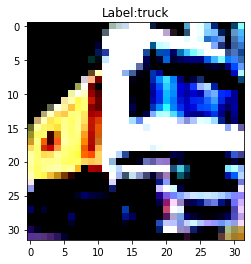

Label of this image: 9 truck
Start training...
epoch: 1 / global_steps: 391
training dataset average loss: 1.860
training_time: 0.34 minutes
validation dataset accuracy: 45.15
epoch: 2 / global_steps: 782
training dataset average loss: 1.350
training_time: 0.72 minutes
validation dataset accuracy: 56.65
epoch: 3 / global_steps: 1173
training dataset average loss: 1.019
training_time: 1.10 minutes
validation dataset accuracy: 63.54
epoch: 4 / global_steps: 1564
training dataset average loss: 0.827
training_time: 1.49 minutes
validation dataset accuracy: 70.93
epoch: 5 / global_steps: 1955
training dataset average loss: 0.718
training_time: 1.88 minutes
validation dataset accuracy: 73.95
epoch: 6 / global_steps: 2346
training dataset average loss: 0.636
training_time: 2.27 minutes
validation dataset accuracy: 72.54
epoch: 7 / global_steps: 2737
training dataset average loss: 0.585
training_time: 2.66 minutes
validation dataset accuracy: 76.74
epoch: 8 / global_steps: 3128
training datase

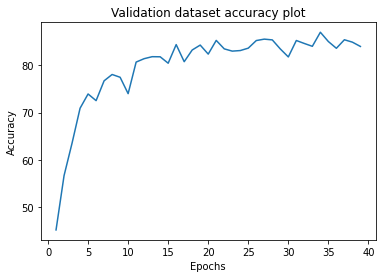

<Figure size 432x288 with 0 Axes>

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

# configuration
cfg = Config()

print('[CIFAR10_training]')
print('Training with:', cfg.modelname)
# GPU 사용이 가능하면 사용하고, 불가능하면 CPU 활용
print("GPU Available:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def generate_batch(train_data, val_data):
    train_batch_loader = DataLoader(train_data, cfg.batch_size, shuffle=True)
    val_batch_loader = DataLoader(val_data, cfg.batch_size, shuffle=True)
    return train_batch_loader, val_batch_loader

def select_optimizer(cfg):
    if cfg.modelname == "LeNet5":
        optimizer = optim.Adam(model.parameters(), lr=cfg.lr)
    elif cfg.modelname == "ResNet32":
        optimizer = optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
        decay_epoch = [32000, 48000]
        step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=decay_epoch, gamma=0.1)

    return optimizer

def train_model(model, train_batch_loader, val_batch_loader, optimizer, criterion):
    # training 시작
    start_time = time.time()
    highest_val_acc = 0
    val_acc_list = []
    global_steps = 0
    epoch = 0
    print('========================================')
    print("Start training...")
    while True:
        train_loss = 0
        train_batch_cnt = 0
        model.train()
        for img, label in train_batch_loader:
            global_steps += 1
            # img.shape: [200,3,32,32]
            # label.shape: [200]

            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            train_loss += loss

            train_batch_cnt += 1

            if global_steps >= cfg.finish_step:
                print("Training finished.")
                break

        ave_loss = train_loss / train_batch_cnt
        training_time = (time.time() - start_time) / 60
        print('========================================')
        print("epoch:", epoch + 1, "/ global_steps:", global_steps)
        print("training dataset average loss: %.3f" % ave_loss)
        print("training_time: %.2f minutes" % training_time)

        # validation (for early stopping)
        correct_cnt = evaluate(model, val_batch_loader, device, verbose = False)
        
        val_acc = correct_cnt / len(val_data) * 100
        print("validation dataset accuracy: %.2f" % val_acc)
        val_acc_list.append(val_acc)
        if val_acc > highest_val_acc:
            save_path = './epoch_' + str(epoch + 1) + '.pth'
            torch.save({'epoch': epoch + 1,
                        'model_state_dict': model.state_dict()},
                       save_path)
            highest_val_acc = val_acc
        epoch += 1
        if global_steps >= cfg.finish_step:
            break

    epoch_list = [i for i in range(1, epoch + 1)]
    plt.title('Validation dataset accuracy plot')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(epoch_list, val_acc_list)
    plt.show()
    plt.savefig("./result.png")


if __name__ == '__main__':
    # 데이터 로드
    # CIFAR10 dataset: [3,32,32] 사이즈의 이미지들을 가진 dataset
    train_data, val_data = data_load(mode = "train")

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # data 개수 확인
    print('The number of training data: ', len(train_data))
    print('The number of validation data: ', len(val_data))

    # shape 및 실제 데이터 확인
    image, label = train_data[1]
    imgshow(image, label, classes)

    # 학습 모델 생성
    model = recall_model(cfg)
    model.to(device)

    # 배치 생성
    train_batch_loader, val_batch_loader = generate_batch(train_data, val_data)

    #loss function, optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = select_optimizer(cfg)

    #Train model
    train_model(model, train_batch_loader, val_batch_loader, optimizer, criterion)

In [8]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from CIFAR10_configuration import Config
# from model.LeNet5_model import LeNet5_model
# from model.ResNet_model import ResNet32_model
# from utils import *

print('[CIFAR10_evaluation]')
cfg = Config()
# GPU 사용이 가능하면 사용하고, 불가능하면 CPU 활용
print("GPU Available:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

def generate_batch(test_data):
    test_batch_loader = DataLoader(test_data, cfg.batch_size, shuffle=True)
    return test_batch_loader

if __name__ == "__main__":

    # 데이터 로드
    test_data = data_load()
    test_data = data_load(mode = "evaluation")
    # data 개수 확인
    print('The number of test data: ', len(test_data))
    # 배치 생성
    test_batch_loader = generate_batch(test_data)

    # test 시작
    acc_list = []

    #TODO
    #save_path 수정하기
    save_path = "./epoch_2.pth"

    # 저장된 model 불러오기
    model, checkpoint = recall_model(cfg, save_path = save_path)
    model.to(device)

    correct_cnt = evaluate(model, test_batch_loader, device, verbose = False)

    accuracy = correct_cnt / len(test_data) * 100
    print("accuracy of the %d epoch trained model : %.2f%%"%(checkpoint["epoch"], accuracy))
    acc_list.append(accuracy)




[CIFAR10_evaluation]
GPU Available: True
device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
The number of test data:  10000
accuracy of the 2 epoch trained model : 56.65%


In [15]:
import torch
from torch.utils.data import DataLoader


print('[CIFAR10_evaluation]')
cfg = Config()
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# GPU 사용이 가능하면 사용하고, 불가능하면 CPU 활용
print("GPU Available:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

if __name__ == "__main__":
    
    #test_example에서 이미지 불러오기
    imgs = data_load(mode = "test example")
    test_loader = DataLoader(imgs, batch_size=1)

    # 저장된 state 불러오기
    #TODO
    #save_path 바꾸기
    save_path = "./epoch_3.pth"
    #모델 불러오기
    model, checkpoint = recall_model(cfg, save_path)
    model.to(device)

    #평가
    evaluate(model, test_loader, device, verbose = True)



[CIFAR10_evaluation]
GPU Available: True
device: cuda:0
--------------------------------------
truth: car
model prediction: car
